## Definir Clase NeuralNetwork

Definir la clase `NeuralNetwork` que implementa una red neuronal feedforward para regresión con NumPy, incluyendo inicialización, funciones de activación (relu, tanh, sigmoid), forward propagation, backward propagation y el método de entrenamiento.


In [40]:
import numpy as np

class NeuralNetwork:
    """
    Red neuronal feedforward (solo NumPy) para REGRESIÓN.
    Caso Pitágoras: entrada [a, b] -> salida [c]
    - >= 2 capas ocultas
    - activación oculta: relu / tanh / sigmoid
    - inicialización: He (relu) o Xavier (tanh/sigmoid)
    - salida lineal + MSE
    """
    def __init__(self, layers, activation='relu', seed=42):
        assert len(layers) >= 4, "Ej: [2, 32, 16, 1] (2 ocultas mínimo)"
        self.layers = layers
        self.activation_name = activation.lower()
        np.random.seed(seed)

        self.W, self.b = [], []
        for l in range(len(layers) - 1):
            fan_in, fan_out = layers[l], layers[l + 1]

            if self.activation_name == 'relu':
                w = np.random.randn(fan_in, fan_out) * np.sqrt(2.0 / fan_in)  # He
            else:
                w = np.random.randn(fan_in, fan_out) * np.sqrt(1.0 / fan_in)  # Xavier

            b = np.zeros((1, fan_out))
            self.W.append(w)
            self.b.append(b)

    def _act(self, Z):
        if self.activation_name == 'relu':
            return np.maximum(0, Z)
        if self.activation_name == 'tanh':
            return np.tanh(Z)
        if self.activation_name == 'sigmoid':
            return 1.0 / (1.0 + np.exp(-Z))
        raise ValueError("activation: 'relu', 'tanh' o 'sigmoid'")

    def _act_deriv(self, Z, A):
        if self.activation_name == 'relu':
            return (Z > 0).astype(float)
        if self.activation_name == 'tanh':
            return 1.0 - A**2
        if self.activation_name == 'sigmoid':
            return A * (1.0 - A)
        raise ValueError("activation: 'relu', 'tanh' o 'sigmoid'")

    def forward(self, X):
        self.cache = {"A": [X], "Z": []}
        A = X
        L = len(self.W)

        for l in range(L):
            Z = A @ self.W[l] + self.b[l]
            self.cache["Z"].append(Z)

            if l < L - 1:
                A = self._act(Z)   # ocultas
            else:
                A = Z              # salida lineal (regresión)

            self.cache["A"].append(A)

        return A  # y_hat

    def backward(self, X, y):
        y_hat = self.cache["A"][-1]
        m = X.shape[0]

        dW = [None] * len(self.W)
        db = [None] * len(self.b)

        # MSE: dL/dy_hat
        dA = (2.0 / m) * (y_hat - y)

        for l in reversed(range(len(self.W))):
            A_prev = self.cache["A"][l]
            Z_l = self.cache["Z"][l]

            if l == len(self.W) - 1:
                dZ = dA  # salida lineal
            else:
                A_l = self.cache["A"][l + 1]
                dZ = dA * self._act_deriv(Z_l, A_l)

            dW[l] = A_prev.T @ dZ
            db[l] = np.sum(dZ, axis=0, keepdims=True)

            dA = dZ @ self.W[l].T

        return dW, db

    def train(self, X, y, epochs=2000, learning_rate=0.01, verbose=200):
        losses = []
        for epoch in range(1, epochs + 1):
            y_hat = self.forward(X)
            loss = np.mean((y_hat - y) ** 2)
            losses.append(loss)

            dW, db = self.backward(X, y)

            for l in range(len(self.W)):
                self.W[l] -= learning_rate * dW[l]
                self.b[l] -= learning_rate * db[l]

            if verbose and (epoch % verbose == 0 or epoch == 1 or epoch == epochs):
                print(f"Epoch {epoch}/{epochs} - MSE: {loss:.6f}")

        return losses

    def predict(self, X):
        return self.forward(X)

## Definir Funciones de Utilidad del Dataset

Definir las funciones `make_pythagoras_data` para generar el dataset de Pitágoras y `standardize_fit` y `standardize_apply` para la normalización de los datos.


In [41]:
import numpy as np

def make_pythagoras_data(n=10000, a_max=20.0, b_max=20.0, seed=1):
    """
    Genera pares (a,b) y su hipotenusa c = sqrt(a^2 + b^2)
    """
    rng = np.random.default_rng(seed)
    a = rng.uniform(0.0, a_max, size=(n, 1))
    b = rng.uniform(0.0, b_max, size=(n, 1))
    c = np.sqrt(a**2 + b**2)
    X = np.hstack([a, b])
    y = c
    return X, y

def standardize_fit(X):
    mu = X.mean(axis=0, keepdims=True)
    sigma = X.std(axis=0, keepdims=True) + 1e-8
    return mu, sigma

def standardize_apply(X, mu, sigma):
    return (X - mu) / sigma

print("Utility functions for dataset generation and standardization defined.")

Utility functions for dataset generation and standardization defined.


## Generar y Preprocesar Datos

### Subtask:
Generar el dataset de Pitágoras, normalizar los datos de entrada (X) y dividir el dataset en conjuntos de entrenamiento y prueba.


In [42]:
X, y = make_pythagoras_data(n=1000, a_max=20, b_max=20, seed=7)

mu, sigma = standardize_fit(X)
Xn = standardize_apply(X, mu, sigma)

idx = np.random.permutation(len(Xn))
split = int(0.8 * len(Xn))
tr, te = idx[:split], idx[split:]
Xtr, ytr = Xn[tr], y[tr]
Xte, yte = Xn[te], y[te]

print("Dataset generated, standardized, and split into training and testing sets.")

Dataset generated, standardized, and split into training and testing sets.


## Inicializar y Entrenar la Red Neuronal

Crear una instancia de la clase `NeuralNetwork` con la arquitectura y activación especificadas, y luego entrenarla usando el conjunto de datos de entrenamiento.


In [43]:
nn = NeuralNetwork(layers=[2, 32, 16, 1], activation='relu', seed=42)
print("Neural Network instance created.")

losses = nn.train(Xtr, ytr, epochs=5000, learning_rate=0.01, verbose=500)
print("Neural Network training complete.")

Neural Network instance created.
Epoch 1/5000 - MSE: 245.279445
Epoch 500/5000 - MSE: 0.137006
Epoch 1000/5000 - MSE: 0.083012
Epoch 1500/5000 - MSE: 0.068410
Epoch 2000/5000 - MSE: 0.045407
Epoch 2500/5000 - MSE: 0.031319
Epoch 3000/5000 - MSE: 0.023229
Epoch 3500/5000 - MSE: 0.016852
Epoch 4000/5000 - MSE: 0.010444
Epoch 4500/5000 - MSE: 0.011566
Epoch 5000/5000 - MSE: 0.006677
Neural Network training complete.


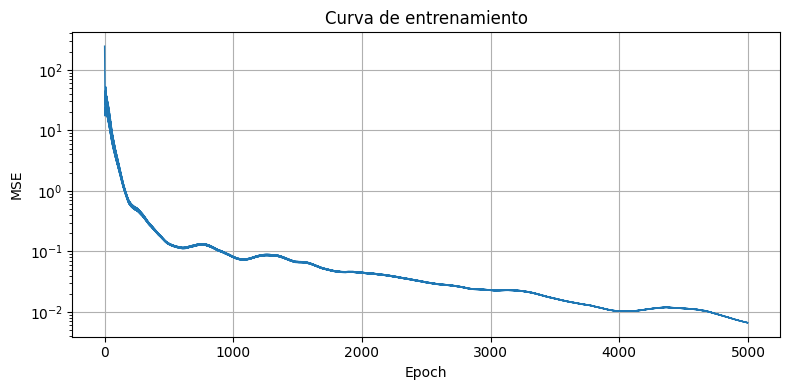

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(losses, color='C0', lw=1)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.yscale("log")
plt.title('Curva de entrenamiento')
plt.grid(True)
plt.tight_layout()
plt.show()

## Evaluar el Rendimiento del Modelo

Realizar predicciones en el conjunto de prueba y calcular las métricas de rendimiento (MSE y MAE) para evaluar la precisión del modelo.


In [45]:
pred_te = nn.predict(Xte)
mse = np.mean((pred_te - yte) ** 2)
mae = np.mean(np.abs(pred_te - yte))

print(f"\nTest MSE: {mse:.6f} | Test MAE: {mae:.6f}")


Test MSE: 0.007259 | Test MAE: 0.074382


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


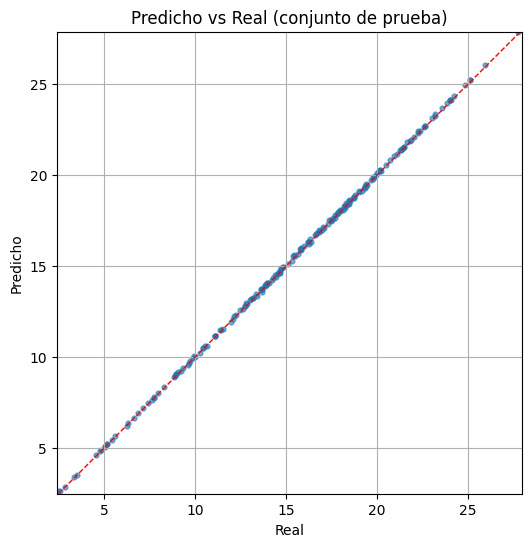

In [46]:
y_real = yte.flatten()
y_pred = pred_te.flatten()

plt.figure(figsize=(6,6))
plt.scatter(y_real, y_pred, s=12, alpha=0.6)
mn, mx = min(y_real.min(), y_pred.min()), max(y_real.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx], 'r--', lw=1)
plt.xlabel('Real')
plt.ylabel('Predicho')
plt.title('Predicho vs Real (conjunto de prueba)')
plt.grid(True)
plt.axis('equal')
plt.xlim(mn, mx)
plt.ylim(mn, mx)
plt.show()

## Probar Caso Específico

Probar la red neuronal con un caso de entrada específico para predecir la hipotenusa y comparar el resultado con el valor real.


In [47]:
cateto_a = 3.0
cateto_b = 4.0

X_test = np.array([[cateto_a, cateto_b]])
X_test_n = standardize_apply(X_test, mu, sigma)
c_pred = nn.predict(X_test_n)[0, 0]
c_real = np.sqrt(cateto_a**2 + cateto_b**2)

print(f"\nPitágoras a={cateto_a}, b={cateto_b} -> predicho: {c_pred:.2f} | real: {c_real:.4f}")


Pitágoras a=3.0, b=4.0 -> predicho: 5.03 | real: 5.0000


## Comparar funciones de activación

Evaluar y comparar activaciones: relu, tanh, sigmoid 

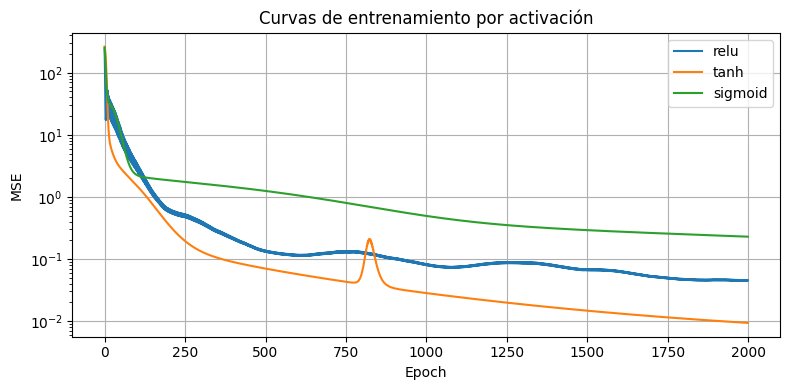

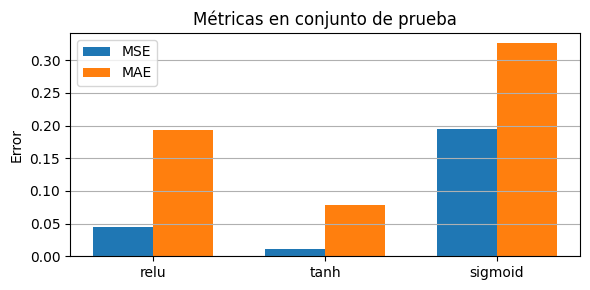

In [48]:
# Evaluar y comparar activaciones: relu, tanh, sigmoid
activations = ['relu', 'tanh', 'sigmoid']
results = {}

for act in activations:
    nn = NeuralNetwork(layers=[2, 32, 16, 1], activation=act, seed=42)
    losses = nn.train(Xtr, ytr, epochs=2000, learning_rate=0.01, verbose=0)
    pred_te = nn.predict(Xte)
    mse = np.mean((pred_te - yte) ** 2)
    mae = np.mean(np.abs(pred_te - yte))
    results[act] = {'losses': np.array(losses), 'pred': pred_te.flatten(), 'mse': mse, 'mae': mae}

# Curvas de entrenamiento (loss)
plt.figure(figsize=(8,4))
for act in activations:
    plt.plot(results[act]['losses'], label=f"{act}")
plt.yscale("log")
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Curvas de entrenamiento por activación')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Comparación de métricas en test (MSE y MAE)
mse_vals = [results[a]['mse'] for a in activations]
mae_vals = [results[a]['mae'] for a in activations]

x = np.arange(len(activations))
width = 0.35
plt.figure(figsize=(6,3))
plt.bar(x - width/2, mse_vals, width, label='MSE')
plt.bar(x + width/2, mae_vals, width, label='MAE')
plt.xticks(x, activations)
plt.ylabel('Error')
plt.title('Métricas en conjunto de prueba')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()